In [190]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

### Studio algoritmi per trovare i prezzi di riferimento per il calcolo delle variazioni di prezzo

In [191]:
# Funzione per generare prezzi casuali basati su una distribuzione delle variazioni
def genera_prezzi(num_giorni, distribuzione_variazioni):
    np.random.seed(0)  # Per riproducibilità
    prezzi = [100]  # Prezzo iniziale
    variazioni = np.random.choice(list(distribuzione_variazioni.keys()), 
                                  size=num_giorni-1, 
                                  p=list(distribuzione_variazioni.values()))
    
    for variazione in variazioni:
        prezzi.append(prezzi[-1] * (1 + variazione))
    
    return pd.DataFrame({'Timestamp': pd.date_range(start='2023-01-01', periods=num_giorni, freq='D'), 
                         'Price': prezzi})

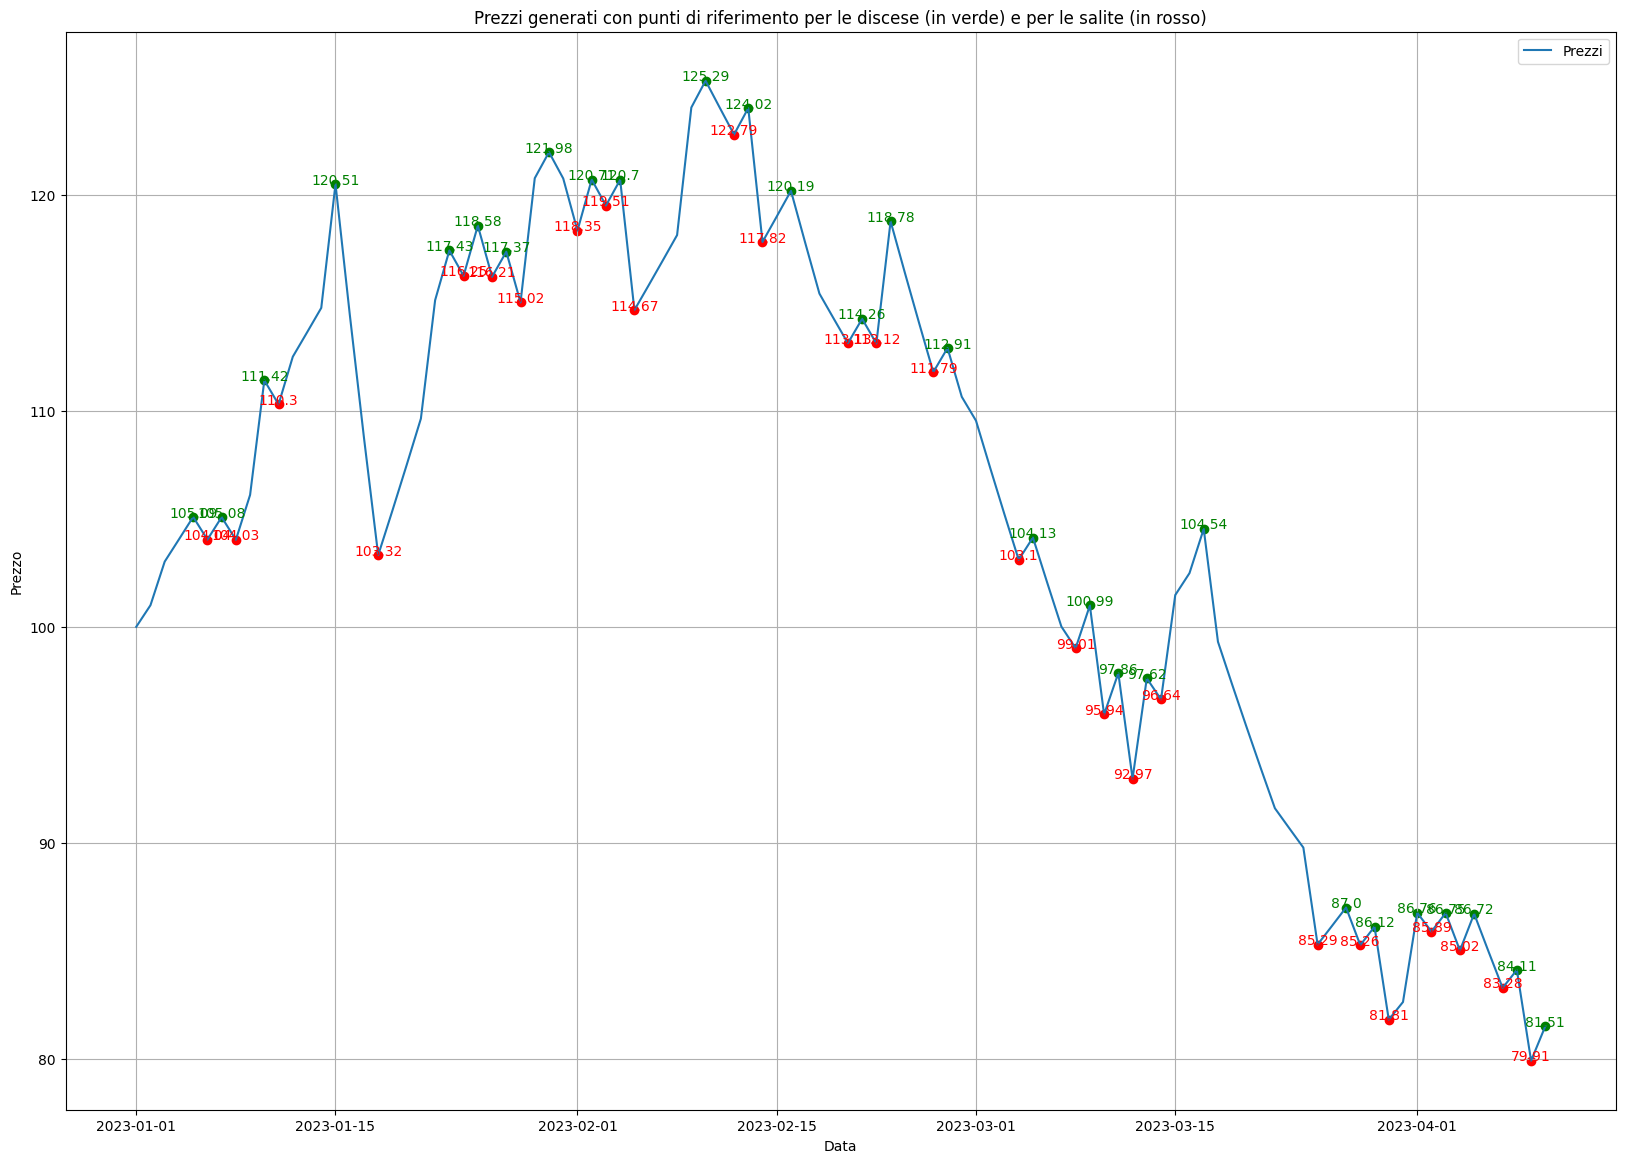

In [192]:
# Distribuzione delle variazioni (esempio)
distribuzione_variazioni = {
    -0.05: 0.1,
    -0.02: 0.2,
    -0.01: 0.2,
    0.01: 0.2,
    0.02: 0.2,
    0.05: 0.1
}

# Genera prezzi
num_giorni = 100
dati = genera_prezzi(num_giorni, distribuzione_variazioni)

# Calcola variazioni
dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

# Parametri
soglia_calcolo_variazioni_discesa = 0.01
soglia_calcolo_variazioni_salita = 0.01

prezzi_riferimento_discesa = []
variazione_cumulata = 1
gia_trovato = False
cont = 0
for j in range(len(dati), 0, -1):
    variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
    if pd.isna(variazione_giorno_precedente):
        continue
    if variazione_giorno_precedente < 1:
        variazione_cumulata = 1
        cont = 0
        gia_trovato = False
        continue
    else:
        variazione_cumulata *= variazione_giorno_precedente
        if variazione_cumulata != variazione_giorno_precedente:
            cont += 1
        if variazione_cumulata - 1 >= soglia_calcolo_variazioni_discesa and not gia_trovato:
            prezzo_riferimento = dati['Price'].iloc[j+cont-1]
            prezzi_riferimento_discesa.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
            variazione_cumulata = 1
            cont = 0
            gia_trovato = True

prezzi_riferimento_salita = []
variazione_cumulata = 1
gia_trovato = False
cont = 0
for j in range(len(dati), 0, -1):
    variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
    if pd.isna(variazione_giorno_precedente):
        continue
    if variazione_giorno_precedente > 1:
        variazione_cumulata = 1
        cont = 0
        gia_trovato = False
        continue
    else:
        variazione_cumulata *= variazione_giorno_precedente
        if variazione_cumulata != variazione_giorno_precedente:
            cont += 1
        if 1 - variazione_cumulata >= soglia_calcolo_variazioni_salita and not gia_trovato:
            prezzo_riferimento = dati['Price'].iloc[j+cont-1]
            prezzi_riferimento_salita.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
            variazione_cumulata = 1
            cont = 0
            gia_trovato = True


# Crea il grafico
plt.figure(figsize=(20, 14))
plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
for timestamp, prezzo_riferimento in prezzi_riferimento_discesa:
    plt.scatter(timestamp, prezzo_riferimento, color='green')
    plt.text(timestamp, prezzo_riferimento, str(round(prezzo_riferimento,2)), color='green', fontsize=10, ha='center')
for timestamp, prezzo_riferimento in prezzi_riferimento_salita:
    plt.scatter(timestamp, prezzo_riferimento, color='red')
    plt.text(timestamp, prezzo_riferimento, str(round(prezzo_riferimento,2)), color='red', fontsize=10, ha='center')

plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Prezzi generati con punti di riferimento per le discese (in verde) e per le salite (in rosso)')
plt.legend()
plt.grid()
plt.show()

In [193]:
dati[:20]

,Timestamp,Price,Variazione
0,2023-01-01,100.000000,NaN
1,2023-01-02,101.000000,1.01
2,2023-01-03,103.020000,1.02
3,2023-01-04,104.050200,1.01
4,2023-01-05,105.090702,1.01
5,2023-01-06,104.039795,0.99
6,2023-01-07,105.080193,1.01
7,2023-01-08,104.029391,0.99
8,2023-01-09,106.109979,1.02
9,2023-01-10,111.415478,1.05


### Algoritmo

In [194]:
# Funzione per calcolare l'ultimo prezzo di riferimento discesa
def calcola_prezzo_riferimento_discesa(dati, soglia_discesa):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente < 1:  # Prezzo in discesa
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if variazione_cumulata - 1 >= soglia_discesa:
                # Se la variazione supera la soglia, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]


# Funzione per calcolare l'ultimo prezzo di riferimento salita
def calcola_prezzo_riferimento_salita(dati, soglia_salita):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente > 1:  # Prezzo in salita
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if 1 - variazione_cumulata >= soglia_salita:
                # Se la variazione supera la soglia, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

def calcola_percentuale(variazione, coefficienti):
    return sum([c * variazione ** i for i,c in enumerate(coefficienti)])

In [195]:
# Parametri della strategia
inverti_riferimento_acquisto = False
inverti_riferimento_vendita = False
acquisto_rispetto_liquidità_iniziale = False
compra_pure = True
vendi_pure = True
soglia_vendita = -np.inf
coefficienti_acquisto = [0, 1]
coefficienti_vendita = [0, 1]

# Parametri per le soglie
soglia_calcolo_variazioni_discesa = 0.05
soglia_calcolo_variazioni_salita = 0.05

# Parametri iniziali
liquidità_iniziale = 1000  # Euro iniziali
bitcoin_iniziali = 0
liquidità = liquidità_iniziale
bitcoin = bitcoin_iniziali
valore_totale_portafoglio = liquidità + bitcoin * dati['Price'][0]

# Calcolo variazioni giornaliere
dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

# Inizializza la lista delle transazioni
df_transazioni = pd.DataFrame(columns=['data', 'prezzo', 'azione', 'Percentuale Liquidità Usata', 'Percentuale Bitcoin Usata', 'quantità_euro', 'Bitcoin Acquistati/Venduti', 'Liquidità', 'Bitcoin', 'valore_totale_portafoglio'])

# Variabili per tenere traccia degli acquisti consecutivi
acquisti_consecutivi = []
quantità_euro_totale = 0  # Somma totale degli euro spesi negli acquisti consecutivi

# Simulazione del trading giorno per giorno
for i in range(len(dati)):
    data_odierna = dati['Timestamp'].iloc[i]
    prezzo_attuale = dati['Price'].iloc[i]
    
    # Calcola i prezzi di riferimento discesa e salita
    timestamp_discesa, prezzo_riferimento_discesa = calcola_prezzo_riferimento_discesa(dati.iloc[:i+1], soglia_calcolo_variazioni_discesa)
    timestamp_salita, prezzo_riferimento_salita = calcola_prezzo_riferimento_salita(dati.iloc[:i+1], soglia_calcolo_variazioni_salita)

    # Scegli il prezzo di riferimento più recente (se esiste)
    prezzo_riferimento = None
    if prezzo_riferimento_discesa is not None and prezzo_riferimento_salita is not None:
        if timestamp_discesa > timestamp_salita:
            prezzo_riferimento = prezzo_riferimento_discesa
            tipo_riferimento = 'discesa'
        else:
            prezzo_riferimento = prezzo_riferimento_salita
            tipo_riferimento = 'salita'
    elif prezzo_riferimento_discesa is not None:
        prezzo_riferimento = prezzo_riferimento_discesa
        tipo_riferimento = 'discesa'
    elif prezzo_riferimento_salita is not None:
        prezzo_riferimento = prezzo_riferimento_salita
        tipo_riferimento = 'salita'

    # Se nessun riferimento è disponibile, passa al giorno successivo
    if prezzo_riferimento is None:
        continue

    # Variabili per tracciare l'azione e la transazione
    azione = '-'
    percentuale_liquidità_usata = 0
    percentuale_bitcoin_usata = 0
    euro_spesi_o_ricavati = 0
    bitcoin_acquistati_o_venduti = 0

    # Logica di acquisto o vendita in base al riferimento più recente
    if tipo_riferimento == 'discesa':  # Logica di acquisto
        if inverti_riferimento_acquisto:
            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_discesa) / prezzo_riferimento_discesa
        else:
            variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa

        percentuale_acquisto = calcola_percentuale(abs(variazione_percentuale), coefficienti_acquisto)
        liquidità_usabile = liquidità_iniziale if acquisto_rispetto_liquidità_iniziale else liquidità
        euro_da_spendere = liquidità_usabile * percentuale_acquisto

        if euro_da_spendere > liquidità:
            if compra_pure:
                euro_da_spendere = liquidità  # Usa tutto
            else:
                euro_da_spendere = 0  # Non fare niente

        if euro_da_spendere > 0:
            bitcoin_acquistati = euro_da_spendere / prezzo_attuale
            liquidità -= euro_da_spendere
            bitcoin += bitcoin_acquistati
            azione = 'Acquisto'
            percentuale_liquidità_usata = percentuale_acquisto
            euro_spesi_o_ricavati = euro_da_spendere
            bitcoin_acquistati_o_venduti = bitcoin_acquistati
            
            # Aggiungi questo acquisto alla lista degli acquisti consecutivi
            acquisti_consecutivi.append((prezzo_attuale, euro_da_spendere))
            quantità_euro_totale += euro_da_spendere

    elif tipo_riferimento == 'salita':  # Logica di vendita
        if inverti_riferimento_vendita:
            variazione_percentuale = (prezzo_riferimento_salita - prezzo_attuale) / prezzo_riferimento_salita
        else:
            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita

        percentuale_vendita = calcola_percentuale(abs(variazione_percentuale), coefficienti_vendita)
        bitcoin_da_vendere = bitcoin * percentuale_vendita

        # Controllo del prezzo di vendita rispetto alla media pesata degli acquisti consecutivi
        if acquisti_consecutivi:
            # Calcolo della media pesata dei prezzi di acquisto
            somma_pesata = sum(prezzo * euro for prezzo, euro in acquisti_consecutivi)
            media_pesata_acquisti = somma_pesata / quantità_euro_totale

            # Verifica che il prezzo attuale sia superiore alla soglia rispetto alla media pesata
            if prezzo_attuale <= media_pesata_acquisti * (1 + soglia_vendita):
                # Se non soddisfa la soglia di vendita, non fare niente
                bitcoin_da_vendere = 0

        if bitcoin_da_vendere > bitcoin:
            if vendi_pure:
                bitcoin_da_vendere = bitcoin  # Vendi tutto
            else:
                bitcoin_da_vendere = 0  # Non fare niente

        if bitcoin_da_vendere > 0:
            euro_ricavati = bitcoin_da_vendere * prezzo_attuale
            bitcoin -= bitcoin_da_vendere
            liquidità += euro_ricavati
            azione = 'Vendita'
            percentuale_bitcoin_usata = percentuale_vendita
            euro_spesi_o_ricavati = euro_ricavati
            bitcoin_acquistati_o_venduti = bitcoin_da_vendere

            # Reset degli acquisti consecutivi dopo una vendita
            acquisti_consecutivi = []
            quantità_euro_totale = 0

    # Aggiorna il valore totale del portafoglio
    valore_totale_portafoglio = liquidità + (bitcoin * prezzo_attuale)

    # Aggiungi la transazione al dataframe
    nuova_transazione = pd.DataFrame([{
        'data': data_odierna,
        'prezzo': prezzo_attuale,
        'azione': azione,
        'Percentuale Liquidità Usata': percentuale_liquidità_usata,
        'Percentuale Bitcoin Usata': percentuale_bitcoin_usata,
        'quantità_euro': euro_spesi_o_ricavati,
        'Bitcoin Acquistati/Venduti': bitcoin_acquistati_o_venduti,
        'Liquidità': liquidità,
        'Bitcoin': bitcoin,
        'valore_totale_portafoglio': valore_totale_portafoglio
    }])

    df_transazioni = pd.concat([df_transazioni, nuova_transazione], ignore_index=True)

# Visualizza il DataFrame delle transazioni
df_transazioni

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_14536\3226400848.py:154: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,data,prezzo,azione,Percentuale Liquidità Usata,Percentuale Bitcoin Usata,quantità_euro,Bitcoin Acquistati/Venduti,Liquidità,Bitcoin,valore_totale_portafoglio
0,2023-01-01,100.000000,-,0,0,0,0,1000,0,1000.000000
1,2023-01-02,101.000000,-,0,0,0,0,1000,0,1000.000000
2,2023-01-03,103.020000,-,0,0,0,0,1000,0,1000.000000
3,2023-01-04,104.050200,-,0,0,0,0,1000,0,1000.000000
4,2023-01-05,105.090702,-,0,0,0,0,1000,0,1000.000000
...,...,...,...,...,...,...,...,...,...,...
95,2023-04-06,84.981075,Acquisto,0.02049,0,4.75347,0.055936,227.236737,7.896673,898.304486
96,2023-04-07,83.281453,Acquisto,0.04008,0,9.107685,0.10936,218.129052,8.006033,884.883131
97,2023-04-08,84.114268,Acquisto,0.030481,0,6.648784,0.079045,211.480268,8.085078,891.550672
98,2023-04-09,79.908554,Acquisto,0.078957,0,16.69783,0.208962,194.782439,8.29404,857.547151


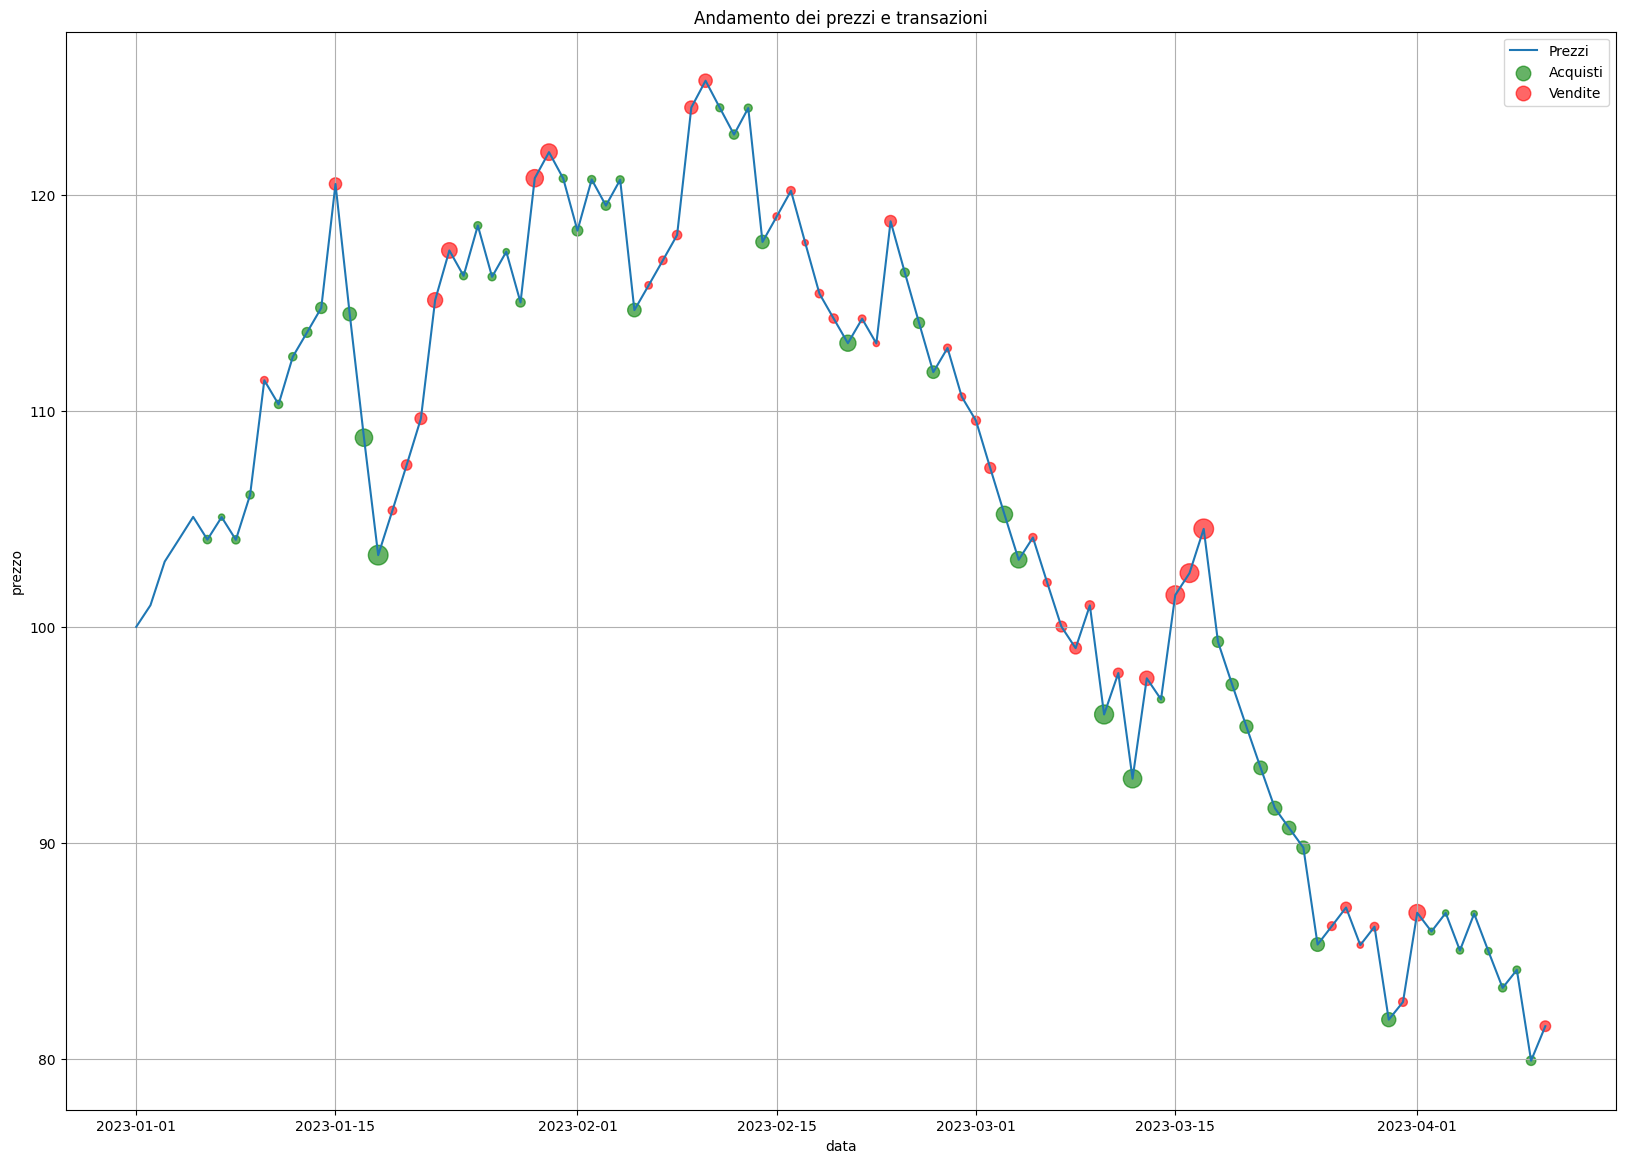

In [196]:
etichette = False

# Preparazione dei dati per il grafico
acquisti = df_transazioni[df_transazioni['azione'].isin(['Acquisto'])]
vendite = df_transazioni[df_transazioni['azione'].isin(['Vendita'])]

# Calcolo delle dimensioni dei punti
max_acquisto = acquisti['quantità_euro'].max()
max_vendita = vendite['quantità_euro'].max()

def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico
plt.figure(figsize=(20, 14))
plt.grid()
plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
if not acquisti.empty:
    plt.scatter(acquisti['data'], acquisti['prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
    if etichette:
        for i, row in acquisti.iterrows():
            plt.text(row['data'], row['prezzo'], f"+{row['quantità_euro']:.2f} €", 
                     color='black', ha='center', va='bottom')
if not vendite.empty:
    plt.scatter(vendite['data'], vendite['prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
    if etichette:
        for i, row in vendite.iterrows():
            plt.text(row['data'], row['prezzo'], f"-{row['quantità_euro']:.2f} €", 
                     color='black', ha='center', va='top')

plt.xlabel('data')
plt.ylabel('prezzo')
plt.title('Andamento dei prezzi e transazioni')
plt.legend()
plt.show()

In [203]:
# Aggiunta della variazione percentuale rispetto al giorno precedente
df_transazioni['Variazione Percentuale'] = df_transazioni['prezzo'].pct_change() * 100

# Preparazione dei dati per il grafico
acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']
vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']

# Calcolo delle dimensioni dei punti
max_acquisto = acquisti['quantità_euro'].max()
max_vendita = vendite['quantità_euro'].max()

def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

# Dimensioni dei punti per acquisti e vendite
dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico dei prezzi con le transazioni
fig = go.Figure()

# Linea dell'andamento dei prezzi
fig.add_trace(go.Scatter(x=df_transazioni['data'], y=df_transazioni['prezzo'], 
                         mode='lines', name='Prezzi',
                         line=dict(color='blue', width=2)))

# Scatter plot per gli acquisti
fig.add_trace(go.Scatter(x=acquisti['data'], y=acquisti['prezzo'],
                         mode='markers', name='Acquisti',
                         marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
                         text=[f"Prezzo: {p:.2f} €<br>Euro usati: {e:.2f} €<br>Variazione: {v:.2f}%" 
                               for p, e, v in zip(acquisti['prezzo'], acquisti['quantità_euro'], acquisti['Variazione Percentuale'])],
                         hoverinfo='text'))

# Scatter plot per le vendite
fig.add_trace(go.Scatter(x=vendite['data'], y=vendite['prezzo'],
                         mode='markers', name='Vendite',
                         marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
                         text=[f"Prezzo: {p:.2f} €<br>Euro ricavati: {e:.2f} €<br>Variazione: {v:.2f}%" 
                               for p, e, v in zip(vendite['prezzo'], vendite['quantità_euro'], vendite['Variazione Percentuale'])],
                         hoverinfo='text'))

# Configurazione del layout
fig.update_layout(
    title='Andamento dei prezzi e transazioni',
    xaxis_title='Data',
    yaxis_title='Prezzo (€)',
    hovermode='closest',
    template='plotly_white',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    width = 1600,
    height = 800
)

# Mostra il grafico
fig.show()

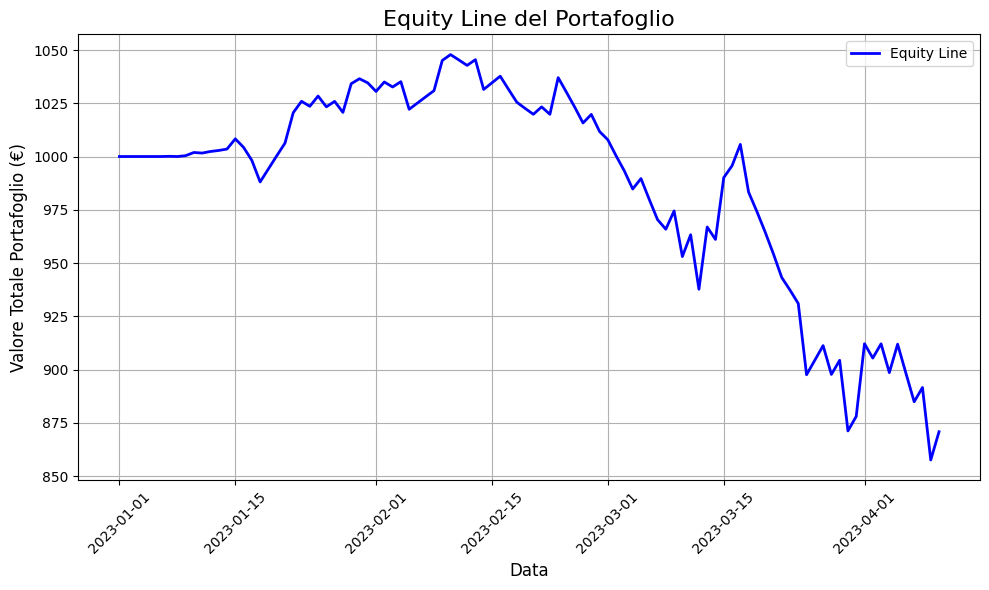

In [198]:
# Assicurati che la colonna 'Data' sia in formato datetime
df_transazioni['data'] = pd.to_datetime(df_transazioni['data'])

# Crea il plot dell'equity line
plt.figure(figsize=(10, 6))
plt.plot(df_transazioni['data'], df_transazioni['valore_totale_portafoglio'], label='Equity Line', color='b', linewidth=2)

# Aggiungi titolo e etichette agli assi
plt.title('Equity Line del Portafoglio', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valore Totale Portafoglio (€)', fontsize=12)

# Aggiungi una griglia per una migliore leggibilità
plt.grid(True)

# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.xticks(rotation=45)  # Ruota le etichette dell'asse x per migliore leggibilità
plt.tight_layout()  # Migliora il layout del grafico
plt.show()

In [199]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [200]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidità_iniziale, bitcoin_iniziali, dati['Price'], 0, 0, 0, 0)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 2.651317965550944
Portafoglio finale ideale in euro: 2651.317965550944


In [201]:
valore_iniziale = df_transazioni['valore_totale_portafoglio'].iloc[0]
valore_finale = df_transazioni['valore_totale_portafoglio'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [202]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {df_transazioni['valore_totale_portafoglio'].iloc[-1]}")

Rendimento del portafoglio: 0.8708024456609693
Punteggio rendimento: 32.84%
Valore finale del portafoglio in euro: 870.8024456609693
